## 1. Efficient Net download
Install efficientnet downloaded from github. If using Kaggle, please switch on internet.

In [1]:
# output is hidden in view version
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-60ew0t6u
     |████████████████████████████████| 50 kB 1.5 MB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=18b8fd03671d3f70de6413584be7853d26ed34f5774dcda18d195ecddb264be0
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbghnj5_/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import packages
<span style = "color:red"> Could we remove the imports that aren't being used? </span>

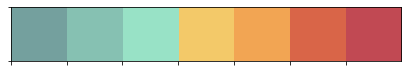

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
# import tensorflow.keras.applications as tfa
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

## 3. Tuned Hyperparameters
We define the number of -
* **epochs** : the number of times we loop through the dataset. 
* **batch_size**: how many training examples to feed into network before updating the weights and internal nodes
* **LR**: learning rate
* **MODEL_CLASS**:  allow us to define which efficientnet model we want to use
* **SAVE_BEST**: defined as true, to only save the model due to 'early stopping' implemented

In [3]:
EPOCHS = 40
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression'

## 4. Train-Test split
We create a test dataset with 20% of unique patients and their associated data; 80% for training. 
Duplicates are dropped as some patients have more than one recorded FVC value for each week. 

In [4]:
all_data = pd.read_csv(f'{path}/train.csv') 
all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

## 5. Data Preprocessing
The original features of the data included Age, Smoking_Status, Sex, Weeks, Percent. However, we would like to transform the data, and include altered features. 

The features that will be fed into the model eventually include:
* baseline Age (numerical)
* baseline Percent (numerical)
* Gender (encoded)
* Smoking status (encoded)

Along with that, the numerical data is normalised and categorical variables are one-hot encoded.

In [5]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [6]:
train = get_baseline_week(train)
#train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
#test = get_baseline_FVC_new(test)

In [7]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [8]:
from sklearn import preprocessing

num_attribs_scld = [s + '_scld' for s in num_attribs]

min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.transform(test[num_attribs])

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474


In [10]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
81,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
82,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
83,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
84,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947


Encoding our categorical variables. 
* Gender: Male: 0, Female: 1
* Smoking_Status: Never Smoked: [0,0], Ex-Smoker: [1,1], Currently Smokes: [0,1]


In [33]:
def get_tab_scaled(df): #getting scaled variables
    vector = [df.Percent_scld.values[0]] # only the first percent value is retained, so this forms the "base_percent"
    vector.extend([df.Age_scld.values[0]]) # only the first age value is retained, so this forms the "base age"
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    
    return np.array(vector)

We need to create the labels i.e y values for our dataset. We aim to predict the rate of FVC values deterioration, which would be the gradient of a linear regression model fit to every available patient. 

In [34]:
A = {} # Gradient of the linear regression of FVC against weeks 
TAB = {} # Initialize tabular data for each patient
P = [] # Patient IDs

# for all 140 train patients we compute the gradient 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values    
    weeks = sub.Weeks.values 
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab_scaled(sub)
    # TAB[p] = get_tab_unscaled(sub)
    P.append(p)

For each sliced ct scan, we need to resize into 512x512 pixel dimensions. 

In [35]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

There are patients (labelled with BAD_IDs ( <span style = "color:red"> why are they bad_IDs maybe we need to explain that ? </span> )) that need to be removed from the training data. This class also transforms the dataframes into the required numpy arrays so that our data can be input into the neural network. 

In [42]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID] # all the patients in the keys  
        self.a = a # gradients found by fitting a linear regression model
        self.tab = tab # tabular data for patient specified in keys
        self.batch_size = batch_size
        
        self.train_data = {} # initialise a dictionary to contain all the images pertaining to one key: patient id 
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 # 1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chosen n patients for one batch  
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [tab] , a

## 7. Model Definition

In [45]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(5,), model_class=None):
    inp = Input(shape=shape) # 5 x 1 x 1 shape
    x = tf.keras.layers.GaussianNoise(0.2)(inp)
    
    #### added ###
    den_1 = Dense(20)(x) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp], y)
    return model

## 8. Model Training

We split the dataset into 5 folds for cross validation purposes. There is early stopping employed in the model and the loss function that we decided upon is RMSE = Root Mean Squared Error. It is a commonly used loss function in regression problems.  <span style = "color:red"> do we need to change mse in the code to rmse ? </span>

In [46]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=8,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=5, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

#####################
####### Fold 0 ######
#####################
Training...
Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 53.8477
Epoch 00001: val_loss improved from inf to 44.79488, saving model to fold-0.h5
32/32 [==============================] - 3s 81ms/step - loss: 53.8477 - val_loss: 44.7949
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 42.9867
Epoch 00002: val_loss did not improve from 44.79488
32/32 [==============================] - 2s 77ms/step - loss: 42.9867 - val_loss: 49.4350
Epoch 3/40
31/32 [============================>.] - ETA: 0s - loss: 32.7815
Epoch 00003: val_loss did not improve from 44.79488
32/32 [==============================] - 2s 70ms/step - loss: 32.2149 - val_loss: 47.9378
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 28.9994
Epoch 00004: val_loss improved from 44.79488 to 38.16969, saving model to fold-0.h5
32/32 [==============================] - 2s 69ms/step - loss: 28.9994 - val_loss:

Epoch 36/40
31/32 [============================>.] - ETA: 0s - loss: 27.1102
Epoch 00036: val_loss did not improve from 25.59807
32/32 [==============================] - 2s 70ms/step - loss: 27.0766 - val_loss: 35.7125
Epoch 37/40
31/32 [============================>.] - ETA: 0s - loss: 33.6143
Epoch 00037: val_loss did not improve from 25.59807
32/32 [==============================] - 2s 69ms/step - loss: 33.6642 - val_loss: 39.4948
Epoch 38/40
32/32 [==============================] - ETA: 0s - loss: 29.6284
Epoch 00038: val_loss did not improve from 25.59807

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0001875000016298145.
32/32 [==============================] - 2s 73ms/step - loss: 29.6284 - val_loss: 32.8675
Epoch 39/40
31/32 [============================>.] - ETA: 0s - loss: 27.4517
Epoch 00039: val_loss did not improve from 25.59807
32/32 [==============================] - 2s 66ms/step - loss: 27.1711 - val_loss: 30.3395
Epoch 40/40
32/32 [========================

Epoch 31/40
31/32 [============================>.] - ETA: 0s - loss: 33.8211
Epoch 00031: val_loss did not improve from 13.53528
32/32 [==============================] - 2s 63ms/step - loss: 33.0896 - val_loss: 22.5720
Epoch 32/40
32/32 [==============================] - ETA: 0s - loss: 32.8399
Epoch 00032: val_loss did not improve from 13.53528
32/32 [==============================] - 2s 71ms/step - loss: 32.8399 - val_loss: 15.1351
Epoch 33/40
32/32 [==============================] - ETA: 0s - loss: 28.7511
Epoch 00033: val_loss did not improve from 13.53528
32/32 [==============================] - 2s 65ms/step - loss: 28.7511 - val_loss: 18.1052
Epoch 34/40
32/32 [==============================] - ETA: 0s - loss: 33.5263
Epoch 00034: val_loss did not improve from 13.53528
32/32 [==============================] - 2s 65ms/step - loss: 33.5263 - val_loss: 19.4682
Epoch 35/40
32/32 [==============================] - ETA: 0s - loss: 36.5118
Epoch 00035: val_loss did not improve from 13.5

Epoch 26/40
31/32 [============================>.] - ETA: 0s - loss: 28.2620
Epoch 00026: val_loss did not improve from 23.85014
32/32 [==============================] - 2s 61ms/step - loss: 28.9524 - val_loss: 25.3355
Epoch 27/40
32/32 [==============================] - ETA: 0s - loss: 26.2192
Epoch 00027: val_loss did not improve from 23.85014
32/32 [==============================] - 2s 67ms/step - loss: 26.2192 - val_loss: 25.4264
Epoch 28/40
31/32 [============================>.] - ETA: 0s - loss: 30.8922
Epoch 00028: val_loss did not improve from 23.85014

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
32/32 [==============================] - 2s 64ms/step - loss: 30.6265 - val_loss: 34.9231
Epoch 29/40
32/32 [==============================] - ETA: 0s - loss: 26.6176
Epoch 00029: val_loss did not improve from 23.85014
32/32 [==============================] - 2s 58ms/step - loss: 26.6176 - val_loss: 31.7489
Epoch 30/40
31/32 [========================

Epoch 21/40
32/32 [==============================] - ETA: 0s - loss: 27.2452
Epoch 00021: val_loss did not improve from 19.30975

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.000375000003259629.
32/32 [==============================] - 2s 57ms/step - loss: 27.2452 - val_loss: 29.6962
Epoch 22/40
31/32 [============================>.] - ETA: 0s - loss: 27.8715
Epoch 00022: val_loss did not improve from 19.30975
32/32 [==============================] - 2s 57ms/step - loss: 27.6600 - val_loss: 24.4362
Epoch 23/40
31/32 [============================>.] - ETA: 0s - loss: 27.8099
Epoch 00023: val_loss did not improve from 19.30975
32/32 [==============================] - 2s 62ms/step - loss: 27.6836 - val_loss: 39.4250
Epoch 24/40
32/32 [==============================] - ETA: 0s - loss: 26.8406
Epoch 00024: val_loss did not improve from 19.30975
32/32 [==============================] - 2s 64ms/step - loss: 26.8406 - val_loss: 41.0073
Epoch 25/40
31/32 [=========================

Epoch 16/40
32/32 [==============================] - ETA: 0s - loss: 29.6898
Epoch 00016: val_loss improved from 22.55379 to 17.48869, saving model to fold-4.h5
32/32 [==============================] - 2s 69ms/step - loss: 29.6898 - val_loss: 17.4887
Epoch 17/40
32/32 [==============================] - ETA: 0s - loss: 34.2440
Epoch 00017: val_loss did not improve from 17.48869
32/32 [==============================] - 2s 60ms/step - loss: 34.2440 - val_loss: 32.5978
Epoch 18/40
31/32 [============================>.] - ETA: 0s - loss: 24.5264
Epoch 00018: val_loss did not improve from 17.48869
32/32 [==============================] - 2s 59ms/step - loss: 24.1957 - val_loss: 31.3499
Epoch 19/40
32/32 [==============================] - ETA: 0s - loss: 31.6902
Epoch 00019: val_loss did not improve from 17.48869
32/32 [==============================] - 2s 62ms/step - loss: 31.6902 - val_loss: 33.4215
Epoch 20/40
31/32 [============================>.] - ETA: 0s - loss: 31.2902
Epoch 00020: va

## 9. Validation Loss examination

In [47]:
min_array = []
for i in range(5):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

0 25.59807014465332
1 13.5352783203125
2 23.850135803222656
3 15.859930038452148
4 17.48868751525879
13.5352783203125


In [48]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

Our mean CV MAE is: 19.266420364379883


min_fold finds out which fold gives the least validation loss

In [49]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [50]:
min_fold

1

^print what is the fold that gives min loss, keep a record below 

In [51]:
################################
# min_fold = 1 #change accordingly
################################
#uncomment for using notebook

1. download the weights from the output and save to zip file and upload them 
2. Restart kernel at this point for fitting weights from best fold to model in model building

building model for prediction

## 10. Model for Test Data

In [54]:
def build_pred_model(shape=(5,), model_class=None, fold=None):
    inp = Input(shape=shape) # 5 x 1 x 1 shape
    x = tf.keras.layers.GaussianNoise(0.2)(inp)
    
    #### added ###
    den_1 = Dense(20)(x) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp], y)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('./') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('./' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    
    #take weights from uploaded weights
    #uncomment when using notebook, instead of when committing notebook
    #weights = [w for w in os.listdir('../input/scaled-weights-genderagepercentsmoker/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/scaled-weights-genderagepercentsmoker/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
models = [build_pred_model(shape=(5,), model_class='b1', fold=min_fold)]

In [57]:
subs = []
q = 0.5
weeks = list(range(-12, 134))
predictions = []
for model in models:
    metric = []
    
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: # what is this? only certain slices are being extracted for patients?
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab_scaled(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        print(len(test[test.Patient == p])) # number of fvc values to predict for every week
        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([tab]) # Predict from all image data and tabular data.
        a = np.quantile(_a, q) # Get the value at the 50th percentile
        
        A_test[p] = a
        print("number of patient FVC data is: ", len(test.FVC.values[test.Patient == p])) # number of times patient takes
        #######################################################################################################################################
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p] #to find the y intercept   #
        #######################################################################################################################################
        print("B_test[p] is: ", B_test[p])
        #B_test is actually to find the intercept
        
        #P_test[p] = test.Percent_scld.values[test.Patient == p] 
        #print("P_test[p] is: ", P_test[p])
        #WEEK[p] = test.baselined_week_scld.values[test.Patient == p]
        #print("WEEK[p] is: ", WEEK[p])
    
    for p in test.Patient.unique():
        for w in weeks:
            patient_prediction = {}
            fvc = A_test[p] * w + B_test[p]  #y = mx + c, A_test[p] = gradient of progression for patient p, w = week_num, B_test[p] is the calculated y_intercept
            print("fvc is: ", fvc)
            patient_prediction = {
                'Week': w,
                'Patient': p,
                'FVC': np.sum(fvc)/len(fvc)
            }
            predictions.append(patient_prediction)
print('done!')

9
number of patient data is:  17
number of patient FVC data is:  9
B_test[p] is:  [1525.91880512 1378.08119488 1377.80199146 1488.52278805 1711.24358463
 1511.40597439 1427.7307539  1435.05553341 1590.82190609]
9
number of patient data is:  233
number of patient FVC data is:  9
B_test[p] is:  [2525.09933281 2856.94922161 2820.79911041 2776.64899921 2988.77372122
 2662.04855442 2732.14788723 2764.67216444 2670.04633045]
9
number of patient data is:  373
number of patient FVC data is:  9
B_test[p] is:  [2778.34292603 2657.91955566 2698.07281494 2741.22607422 2766.3793335
 2896.83911133 2555.75866699 2419.25485229 2569.48092651]
9
number of patient data is:  225
number of patient FVC data is:  9
B_test[p] is:  [3973.96768665 3960.93537331 3856.91921663 4067.24177885 4088.56434107
 3942.87074661 4013.80611992 4106.40277433 4189.66070986]
6
number of patient data is:  67
number of patient FVC data is:  6
B_test[p] is:  [3322.3793602  3253.7587204  3398.1380806  3166.5174408  3282.89680099
 

fvc is:  [2572.39459229 2451.97122192 2492.1244812  2535.27774048 2560.43099976
 2690.89077759 2349.81033325 2213.30651855 2363.53259277]
fvc is:  [2567.81796265 2447.39459229 2487.54785156 2530.70111084 2555.85437012
 2686.31414795 2345.23370361 2208.72988892 2358.95596313]
fvc is:  [2563.24133301 2442.81796265 2482.97122192 2526.1244812  2551.27774048
 2681.73751831 2340.65707397 2204.15325928 2354.3793335 ]
fvc is:  [2558.66470337 2438.24133301 2478.39459229 2521.54785156 2546.70111084
 2677.16088867 2336.08044434 2199.57662964 2349.80270386]
fvc is:  [2554.08807373 2433.66470337 2473.81796265 2516.97122192 2542.1244812
 2672.58425903 2331.5038147  2195.         2345.22607422]
fvc is:  [2549.51144409 2429.08807373 2469.24133301 2512.39459229 2537.54785156
 2668.00762939 2326.92718506 2190.42337036 2340.64944458]
fvc is:  [2544.93481445 2424.51144409 2464.66470337 2507.81796265 2532.97122192
 2663.43099976 2322.35055542 2185.84674072 2336.07281494]
fvc is:  [2540.35818481 2419.934814

fvc is:  [1425.68650055 1480.35812569 1506.02975082 1501.04462624 1514.07437706
 1533.77575302 1563.47712898]
fvc is:  [1422.35068798 1477.02231312 1502.69393826 1497.70881367 1510.73856449
 1530.43994045 1560.14131641]
fvc is:  [1419.01487541 1473.68650055 1499.35812569 1494.3730011  1507.40275192
 1527.10412788 1556.80550385]
fvc is:  [1415.67906284 1470.35068798 1496.02231312 1491.03718853 1504.06693935
 1523.76831532 1553.46969128]
fvc is:  [1412.34325027 1467.01487541 1492.68650055 1487.70137596 1500.73112679
 1520.43250275 1550.13387871]
fvc is:  [1409.00743771 1463.67906284 1489.35068798 1484.36556339 1497.39531422
 1517.09669018 1546.79806614]
fvc is:  [1405.67162514 1460.34325027 1486.01487541 1481.02975082 1494.05950165
 1513.76087761 1543.46225357]
fvc is:  [1402.33581257 1457.00743771 1482.67906284 1477.69393826 1490.72368908
 1510.42506504 1540.126441  ]
fvc is:  [1399.         1453.67162514 1479.34325027 1474.35812569 1487.38787651
 1507.08925247 1536.79062843]
fvc is:  [

 2591.5609169  2848.11015701 3137.1218338  3143.05838394]
fvc is:  [2320.31218338 2629.54924011 2244.47411346 2440.93655014 2450.32386017
 2587.09848022 2843.64772034 3132.65939713 3138.59594727]
fvc is:  [2315.8497467  2625.08680344 2240.01167679 2436.47411346 2445.86142349
 2582.63604355 2839.18528366 3128.19696045 3134.13351059]
fvc is:  [2311.38731003 2620.62436676 2235.54924011 2432.01167679 2441.39898682
 2578.17360687 2834.72284698 3123.73452377 3129.67107391]
fvc is:  [2306.92487335 2616.16193008 2231.08680344 2427.54924011 2436.93655014
 2573.7111702  2830.26041031 3119.2720871  3125.20863724]
fvc is:  [2302.46243668 2611.69949341 2226.62436676 2423.08680344 2432.47411346
 2569.24873352 2825.79797363 3114.80965042 3120.74620056]
fvc is:  [2298.         2607.23705673 2222.16193008 2418.62436676 2428.01167679
 2564.78629684 2821.33553696 3110.34721375 3116.28376389]
fvc is:  [2293.53756332 2602.77462006 2217.69949341 2414.16193008 2423.54924011
 2560.32386017 2816.87310028 3105.

fvc is:  [2493.44273996 2459.45800686 2474.48854065 2521.53434134 2351.56487513
 2257.6412096  2252.82441235 2002.02288198]
fvc is:  [2489.42747307 2455.44273996 2470.47327375 2517.51907444 2347.54960823
 2253.62594271 2248.80914545 1998.00761509]
fvc is:  [2485.41220617 2451.42747307 2466.45800686 2513.50380754 2343.53434134
 2249.61067581 2244.79387856 1993.99234819]
fvc is:  [2481.39693928 2447.41220617 2462.44273996 2509.48854065 2339.51907444
 2245.59540892 2240.77861166 1989.9770813 ]
fvc is:  [2477.38167238 2443.39693928 2458.42747307 2505.47327375 2335.50380754
 2241.58014202 2236.76334476 1985.9618144 ]
fvc is:  [2473.36640549 2439.38167238 2454.41220617 2501.45800686 2331.48854065
 2237.56487513 2232.74807787 1981.94654751]
fvc is:  [2469.35113859 2435.36640549 2450.39693928 2497.44273996 2327.47327375
 2233.54960823 2228.73281097 1977.93128061]
fvc is:  [2465.3358717  2431.35113859 2446.38167238 2493.42747307 2323.45800686
 2229.53434134 2224.71754408 1973.91601372]
fvc is: 

fvc is:  [1754.85640526 1656.95514679 1587.68764114 1460.78638268 1119.51887703
  914.71636009  815.74507904  857.87253952]
fvc is:  [1750.49015808 1652.58889961 1583.32139397 1456.4201355  1115.15262985
  910.35011292  811.37883186  853.50629234]
fvc is:  [1746.1239109  1648.22265244 1578.95514679 1452.05388832 1110.78638268
  905.98386574  807.01258469  849.14004517]
fvc is:  [1741.75766373 1643.85640526 1574.58889961 1447.68764114 1106.4201355
  901.61761856  802.64633751  844.77379799]
fvc is:  [1737.39141655 1639.49015808 1570.22265244 1443.32139397 1102.05388832
  897.25137138  798.28009033  840.40755081]
fvc is:  [1733.02516937 1635.1239109  1565.85640526 1438.95514679 1097.68764114
  892.88512421  793.91384315  836.04130363]
fvc is:  [1728.6589222  1630.75766373 1561.49015808 1434.58889961 1093.32139397
  888.51887703  789.54759598  831.67505646]
fvc is:  [1724.29267502 1626.39141655 1557.1239109  1430.22265244 1088.95514679
  884.15262985  785.1813488   827.30880928]
fvc is:  

fvc is:  [2069.07566833 2119.07301331 2261.57102203 2197.07035828 2111.06903076
 2167.06504822 2201.05708313 2297.04911804 2337.53783417]
fvc is:  [2064.57633209 2114.57367706 2257.07168579 2192.57102203 2106.56969452
 2162.56571198 2196.55774689 2292.5497818  2333.03849792]
fvc is:  [2060.07699585 2110.07434082 2252.57234955 2188.07168579 2102.07035828
 2158.06637573 2192.05841064 2288.05044556 2328.53916168]
fvc is:  [2055.57765961 2105.57500458 2248.07301331 2183.57234955 2097.57102203
 2153.56703949 2187.5590744  2283.55110931 2324.03982544]
fvc is:  [2051.07832336 2101.07566833 2243.57367706 2179.07301331 2093.07168579
 2149.06770325 2183.05973816 2279.05177307 2319.5404892 ]
fvc is:  [2046.57898712 2096.57633209 2239.07434082 2174.57367706 2088.57234955
 2144.568367   2178.56040192 2274.55243683 2315.04115295]
fvc is:  [2042.07965088 2092.07699585 2234.57500458 2170.07434082 2084.07301331
 2140.06903076 2174.06106567 2270.05310059 2310.54181671]
fvc is:  [2037.58031464 2087.57765

fvc is:  [4083.15926075 3941.5675621  4053.97586346 4164.38416481 4094.79246616
 3942.01737022 3842.46717834 3837.91698647 4049.18339729 4089.        ]
fvc is:  [4082.45511007 3940.86341143 4053.27171278 4163.68001413 4094.08831549
 3941.31321955 3841.76302767 3837.21283579 4048.47924662 4088.29584932]
fvc is:  [4081.7509594  3940.15926075 4052.5675621  4162.97586346 4093.38416481
 3940.60906887 3841.05887699 3836.50868511 4047.77509594 4087.59169865]
fvc is:  [4081.04680872 3939.45511007 4051.86341143 4162.27171278 4092.68001413
 3939.90491819 3840.35472631 3835.80453444 4047.07094526 4086.88754797]
fvc is:  [4080.34265804 3938.7509594  4051.15926075 4161.5675621  4091.97586346
 3939.20076752 3839.65057564 3835.10038376 4046.36679459 4086.18339729]
fvc is:  [4079.63850737 3938.04680872 4050.45511007 4160.86341143 4091.27171278
 3938.49661684 3838.94642496 3834.39623308 4045.66264391 4085.47924662]
fvc is:  [4078.93435669 3937.34265804 4049.7509594  4160.15926075 4090.5675621
 3937.792

fvc is:  [2182.02754974 2240.24299622 2212.62420654 2220.00541687 2103.07723236
 2227.22086334 2258.50812531 1991.79538727 2143.84506989]
fvc is:  [2178.33694458 2236.55239105 2208.93360138 2216.31481171 2099.3866272
 2223.53025818 2254.81752014 1988.1047821  2140.15446472]
fvc is:  [2174.64633942 2232.86178589 2205.24299622 2212.62420654 2095.69602203
 2219.83965302 2251.12691498 1984.41417694 2136.46385956]
fvc is:  [2170.95573425 2229.17118073 2201.55239105 2208.93360138 2092.00541687
 2216.14904785 2247.43630981 1980.72357178 2132.77325439]
fvc is:  [2167.26512909 2225.48057556 2197.86178589 2205.24299622 2088.31481171
 2212.45844269 2243.74570465 1977.03296661 2129.08264923]
fvc is:  [2163.57452393 2221.7899704  2194.17118073 2201.55239105 2084.62420654
 2208.76783752 2240.05509949 1973.34236145 2125.39204407]
fvc is:  [2159.88391876 2218.09936523 2190.48057556 2197.86178589 2080.93360138
 2205.07723236 2236.36449432 1969.65175629 2121.7014389 ]
fvc is:  [2156.1933136  2214.408760

 1722.26400566 1882.87046051 1903.81488037]
fvc is:  [1677.99551582 1710.65755081 1768.98162079 2000.96772575 1829.62976074
 1718.60197067 1879.20842552 1900.15284538]
fvc is:  [1674.33348083 1706.99551582 1765.3195858  1997.30569077 1825.96772575
 1714.93993568 1875.54639053 1896.49081039]
fvc is:  [1670.67144585 1703.33348083 1761.65755081 1993.64365578 1822.30569077
 1711.2779007  1871.88435555 1892.82877541]
fvc is:  [1667.00941086 1699.67144585 1757.99551582 1989.98162079 1818.64365578
 1707.61586571 1868.22232056 1889.16674042]
fvc is:  [1663.34737587 1696.00941086 1754.33348083 1986.3195858  1814.98162079
 1703.95383072 1864.56028557 1885.50470543]
fvc is:  [1659.68534088 1692.34737587 1750.67144585 1982.65755081 1811.3195858
 1700.29179573 1860.89825058 1881.84267044]
fvc is:  [1656.02330589 1688.68534088 1747.00941086 1978.99551582 1807.65755081
 1696.62976074 1857.23621559 1878.18063545]
fvc is:  [1652.3612709  1685.02330589 1743.34737587 1975.33348083 1803.99551582
 1692.967

 2103.94125032 2124.43463755 1684.92802477 1911.25254107]
fvc is:  [2139.3245163  1969.74008083 2207.15564537 2248.57120991 2132.98677444
 2100.23346806 2120.72685528 1681.2202425  1907.5447588 ]
fvc is:  [2135.61673403 1966.03229856 2203.4478631  2244.86342764 2129.27899218
 2096.52568579 2117.01907301 1677.51246023 1903.83697653]
fvc is:  [2131.90895176 1962.3245163  2199.74008083 2241.15564537 2125.57120991
 2092.81790352 2113.31129074 1673.80467796 1900.12919426]
fvc is:  [2128.20116949 1958.61673403 2196.03229856 2237.4478631  2121.86342764
 2089.11012125 2109.60350847 1670.09689569 1896.42141199]
fvc is:  [2124.49338722 1954.90895176 2192.3245163  2233.74008083 2118.15564537
 2085.40233898 2105.8957262  1666.38911343 1892.71362972]
fvc is:  [2120.78560495 1951.20116949 2188.61673403 2230.03229856 2114.4478631
 2081.69455671 2102.18794394 1662.68133116 1889.00584745]
fvc is:  [2117.07782269 1947.49338722 2184.90895176 2226.3245163  2110.74008083
 2077.98677444 2098.48016167 1658.9

fvc is:  [1339.96181107 1271.06562996 1227.16944885 1321.27326775 1233.37708664
 1506.68854332 1466.31145668 1501.93437004 1424.76492119]
fvc is:  [1336.40990162 1267.51372051 1223.61753941 1317.7213583  1229.82517719
 1503.13663387 1462.75954723 1498.38246059 1421.21301174]
fvc is:  [1332.85799217 1263.96181107 1220.06562996 1314.16944885 1226.27326775
 1499.58472443 1459.20763779 1494.83055115 1417.66110229]
fvc is:  [1329.30608273 1260.40990162 1216.51372051 1310.61753941 1222.7213583
 1496.03281498 1455.65572834 1491.2786417  1414.10919285]
fvc is:  [1325.75417328 1256.85799217 1212.96181107 1307.06562996 1219.16944885
 1492.48090553 1452.10381889 1487.72673225 1410.5572834 ]
fvc is:  [1322.20226383 1253.30608273 1209.40990162 1303.51372051 1215.61753941
 1488.92899609 1448.55190945 1484.17482281 1407.00537395]
fvc is:  [1318.65035439 1249.75417328 1205.85799217 1299.96181107 1212.06562996
 1485.37708664 1445.         1480.62291336 1403.45346451]
fvc is:  [1315.09844494 1246.202263

fvc is:  [3389.2233963  3408.6505661  3303.864151   3257.60201263 3297.81559753
 3354.5049057  3261.09710693 3263.47572327 3058.01937103]
fvc is:  [3384.48553467 3403.91270447 3299.12628937 3252.864151   3293.0777359
 3349.76704407 3256.3592453  3258.73786163 3053.2815094 ]
fvc is:  [3379.74767303 3399.17484283 3294.38842773 3248.12628937 3288.33987427
 3345.02918243 3251.62138367 3254.         3048.54364777]
fvc is:  [3375.0098114  3394.4369812  3289.6505661  3243.38842773 3283.60201263
 3340.2913208  3246.88352203 3249.26213837 3043.80578613]
fvc is:  [3370.27194977 3389.69911957 3284.91270447 3238.6505661  3278.864151
 3335.55345917 3242.1456604  3244.52427673 3039.0679245 ]
fvc is:  [3365.53408813 3384.96125793 3280.17484283 3233.91270447 3274.12628937
 3330.81559753 3237.40779877 3239.7864151  3034.33006287]
fvc is:  [3360.7962265  3380.2233963  3275.4369812  3229.17484283 3269.38842773
 3326.0777359  3232.66993713 3235.04855347 3029.59220123]
fvc is:  [3356.05836487 3375.48553467

fvc is:  [1727.52406216 1752.88180256 1719.56067276 1683.23954296 1724.91841316
 1684.95502377 1608.04655027]
fvc is:  [1723.18462706 1748.54236746 1715.22123766 1678.90010786 1720.57897806
 1680.61558867 1603.70711517]
fvc is:  [1718.84519196 1744.20293236 1710.88180256 1674.56067276 1716.23954296
 1676.27615356 1599.36768007]
fvc is:  [1714.50575686 1739.86349726 1706.54236746 1670.22123766 1711.90010786
 1671.93671846 1595.02824497]
fvc is:  [1710.16632175 1735.52406216 1702.20293236 1665.88180256 1707.56067276
 1667.59728336 1590.68880987]
fvc is:  [1705.82688665 1731.18462706 1697.86349726 1661.54236746 1703.22123766
 1663.25784826 1586.34937477]
fvc is:  [1701.48745155 1726.84519196 1693.52406216 1657.20293236 1698.88180256
 1658.91841316 1582.00993967]
fvc is:  [1697.14801645 1722.50575686 1689.18462706 1652.86349726 1694.54236746
 1654.57897806 1577.67050457]
fvc is:  [1692.80858135 1718.16632175 1684.84519196 1648.52406216 1690.20293236
 1650.23954296 1573.33106947]
fvc is:  [

fvc is:  [2545.42214394 2276.0124855  2322.19316864 2301.37385178 2107.55453491
 2328.09658432 2508.59034157 2480.26478195]
fvc is:  [2540.83180237 2271.42214394 2317.60282707 2296.78351021 2102.96419334
 2323.50624275 2504.         2475.67444038]
fvc is:  [2536.2414608  2266.83180237 2313.0124855  2292.19316864 2098.37385178
 2318.91590118 2499.40965843 2471.08409882]
fvc is:  [2531.65111923 2262.2414608  2308.42214394 2287.60282707 2093.78351021
 2314.32555962 2494.81931686 2466.49375725]
fvc is:  [2527.06077766 2257.65111923 2303.83180237 2283.0124855  2089.19316864
 2309.73521805 2490.2289753  2461.90341568]
fvc is:  [2522.4704361  2253.06077766 2299.2414608  2278.42214394 2084.60282707
 2305.14487648 2485.63863373 2457.31307411]
fvc is:  [2517.88009453 2248.4704361  2294.65111923 2273.83180237 2080.0124855
 2300.55453491 2481.04829216 2452.72273254]
fvc is:  [2513.28975296 2243.88009453 2290.06077766 2269.2414608  2075.42214394
 2295.96419334 2476.45795059 2448.13239098]
fvc is:  

fvc is:  [2390.91235542 2417.19469261 2425.4770298  2499.75936699 2542.04170418
 2432.88871574 2605.58273888 2603.9179306 ]
fvc is:  [2386.27118683 2412.55352402 2420.83586121 2495.11819839 2537.40053558
 2428.24754715 2600.94157028 2599.27676201]
fvc is:  [2381.63001823 2407.91235542 2416.19469261 2490.4770298  2532.75936699
 2423.60637856 2596.30040169 2594.63559341]
fvc is:  [2376.98884964 2403.27118683 2411.55352402 2485.83586121 2528.11819839
 2418.96520996 2591.65923309 2589.99442482]
fvc is:  [2372.34768105 2398.63001823 2406.91235542 2481.19469261 2523.4770298
 2414.32404137 2587.0180645  2585.35325623]
fvc is:  [2367.70651245 2393.98884964 2402.27118683 2476.55352402 2518.83586121
 2409.68287277 2582.3768959  2580.71208763]
fvc is:  [2363.06534386 2389.34768105 2397.63001823 2471.91235542 2514.19469261
 2405.04170418 2577.73572731 2576.07091904]
fvc is:  [2358.42417526 2384.70651245 2392.98884964 2467.27118683 2509.55352402
 2400.40053558 2573.09455872 2571.42975044]
fvc is:  

In [58]:
predictions

[{'Week': -12,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1534.3895052803887},
 {'Week': -11,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1531.0291069878472},
 {'Week': -10,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1527.6687086953057},
 {'Week': -9,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1524.3083104027642},
 {'Week': -8,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1520.9479121102227},
 {'Week': -7,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1517.5875138176812},
 {'Week': -6,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1514.2271155251397},
 {'Week': -5,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1510.8667172325981},
 {'Week': -4,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1507.5063189400566},
 {'Week': -3,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1504.1459206475151},
 {'Week': -2,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1500.7855223549736},
 {'Week': -1,
  'Patient': 'ID000236372021791046030

In [66]:
# GET RESULTS INTO A DATAFRAME 
predictions_df = pd.DataFrame(predictions)
# predictions_df.to_csv("test_predictions_GAPS_scaled.csv")

pred_patients are unique patientID of patients in the predictions 

In [67]:
pred_patients  = predictions_df.Patient.unique()

In [68]:
predictions_df.rename(columns = {'Week': 'Weeks'}, inplace = True)

In [69]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'Weeks'], how = 'inner')

In [70]:
merged_data 

,Weeks,Patient,FVC_x,FVC_y,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,-3,ID00023637202179104603099,1504.145921,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
1,3,ID00023637202179104603099,1483.983531,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
2,5,ID00023637202179104603099,1477.262734,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
3,7,ID00023637202179104603099,1470.541938,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
4,9,ID00023637202179104603099,1463.821141,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...
307,21,ID00421637202311550012437,2809.962450,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000
308,23,ID00421637202311550012437,2800.680113,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000
309,29,ID00421637202311550012437,2772.833101,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000
310,41,ID00421637202311550012437,2717.139078,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000


In [71]:
rmse = np.sqrt((1/len(merged_data)) * sum(np.square(merged_data.FVC_x - merged_data.FVC_y)))  #change this part for non_scaled

In [72]:
# 144.413 (for pyotrch part 2 rmse)
# around 142 for this version
rmse 

142.1081754134354

In [73]:
#rmse for unscaled notebook with percent included = 143.2077201851251